In [3]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from numba import jit, njit, types, vectorize, prange
from numba import jitclass, int32, float32, int64, float64
from numba.typed import List
from multiprocessing import Pool
from os import listdir
from os.path import isfile, join
from sklearn.cluster import KMeans
from scipy.integrate import cumtrapz

In [2]:
def step(tt):
    out = np.zeros_like(tt)
    out[tt >= 0] = 1
    return out

def ramp(tt):
    out = np.array(tt)
    out[tt < 0] = 0
    return out

def jitter(gain, omega, tt, t0, tf):
    out = np.array(tt)
    
    out = gain * np.sin(omega*(tt-t0))
    out[tt-t0 < 0] = 0
    out[tt-tf > 0] = 0
    return out

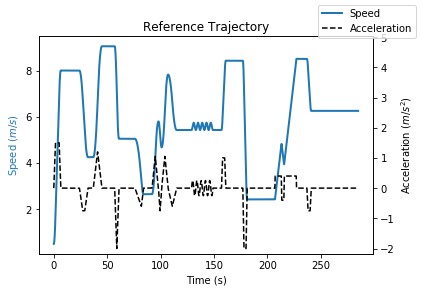

In [3]:
t0 = np.arange(3, 288, 0.01)
a0 = ramp(t0-3) - ramp(t0-4.5) - ramp(t0-8) + ramp(t0-9.5) \
    - 0.25*ramp(t0-27) + 0.25*ramp(t0-30) + 0.25*ramp(t0-32) - 0.25*ramp(t0-35) \
    + 0.3*ramp(t0-40) - 0.6*ramp(t0-44) + 0.3*ramp(t0-48) \
    - 1*ramp(t0-60) + 2*ramp(t0 - 62) - 1*ramp(t0-64) \
    - 0.1*ramp(t0-79) + 0.4*ramp(t0-85) - 0.3*ramp(t0-87) \
    + 0.35*ramp(t0-95) - 0.7*ramp(t0-98) + 0.35*ramp(t0-101) \
    - 0.5*ramp(t0-101) + 1*ramp(t0-102.5) - 0.5*ramp(t0-104) \
    + 0.35*ramp(t0-104) - 0.7*ramp(t0-107) + 0.35*ramp(t0-110) \
    - 0.15*ramp(t0-110) + 0.3*ramp(t0-114) - 0.15*ramp(t0-118) \
    + jitter(0.25, np.pi / 2.0, t0, 132, 152) \
    + 1.*ramp(t0-160) - 1.*ramp(t0-161) - 1.*ramp(t0-163) + 1.*ramp(t0-164) \
    - 2.*ramp(t0 - 180) + 2*ramp(t0-181) + 2 *ramp(t0-183) - 2*ramp(t0-184) \
    + 2.0 * ramp(t0-210) - 2.0*ramp(t0-210.2) - 2.0*ramp(t0-216) + 2.0*ramp(t0-216.4)\
    + 2.0 * ramp(t0-218.4) - 2.0*ramp(t0-218.8)  - 2.0*ramp(t0 - 230) + 2.0*ramp(t0-230.2) \
    - 0.75*ramp(t0-240) + 0.75*ramp(t0-241) + 0.75*ramp(t0-243) - 0.75*ramp(t0-244) #\
    #+ 5.0*step(t0-255) - 5.0*step(t0-256)
t0 = np.arange(0, 285, 0.01)
v0 = cumtrapz(a0, t0, initial=0.) + 0.5

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.plot(t0, v0, color='tab:blue', linewidth=2.0, label='Speed')
ax1.set_ylabel('Speed 'r'$(m/s)$', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(t0, a0, color='black', linestyle='--', linewidth=1.5, label='Acceleration')
ax2.set_ylabel('Acceleration '+r'$(m/s^2)$', color='black')
ax2.set_ylim(ax2.get_ylim()[0], 3 * ax2.get_ylim()[1])

fig.legend()
plt.title('Reference Trajectory')
plt.show()

In [4]:
# Steady State Response
param_ssr = np.load('/model/steady_state_response_history.npy')[-1]

# Dynamics
param_dynamics = np.load('/model/system_history.npy')[-1]

In [5]:
print(param_ssr)
print(param_dynamics)

[ 0.95959429 -0.12973389 -0.15346456]
[-9.32977948e-01 -8.76899268e-01 -3.81319388e-06  2.33466279e+00
  5.20318838e+00  5.56628511e-02  2.09908015e-01 -5.62895447e-01
 -1.38426110e+01 -2.04113361e-01 -6.71627133e-01  8.60289954e-02
  1.36439056e+02  3.02852036e+01  8.87338285e+01  4.19427450e+01
 -3.10163967e-01]


In [6]:
# Steady state response parameters
beta1, beta2, beta3 = param_ssr

# System parameters
a1, a2, a3, b1, b2, b3, b4, c1, c2, c3, c4, td11, td12, td13, td21, td22, td23 = param_dynamics
td11 = int(np.around(td11))
td12 = int(np.around(td12))
td13 = int(np.around(td13))
td21 = int(np.around(td21))
td22 = int(np.around(td22))
td23 = int(np.around(td23))

In [7]:
@njit
def delayed_control_signal(i, u, u_list, td):
    if i < td:
        ut = 0.0
    else:
        if td == 0:
            ut = u
        else:
            ut = u_list[i-td]
    return ut
_ = delayed_control_signal(1, 0.1, np.array([0.1, 0.2, 0.3]), 0)

In [8]:
@njit ("float64(float64, float64, float64)")
def clip(input_, min_, max_):
    if input_ > max_:
        return max_
    elif input_ < min_:
        return min_
    else:
        return input_
    
_ = clip(2.0, -1.0, 1.0)

In [9]:
@njit
def PID_Control(k, v, t, min_, max_):
    # Initialize the constants
    kp, ki, kd = k
    PID = np.zeros(t.shape)
    P_ = 0
    I_ = 0
    D_ = 0
    err = 0
    e_sum = 0
    e_last = 0
    
    u1_list = np.empty(t.shape)
    u2_list = np.empty(t.shape)
    out = np.empty(t.shape)
    y = 0
    
    e_sum = e_sum + err*(t[1] - t[0])
    
    # PID Loop
    for i in range(t.shape[0]):
        sp = clip(v[i], 0.0, np.Inf)
        sr = clip(beta1 * (1.0 - np.exp(beta2*sp + beta3*sp**(0.1))), 0.0, 1.0)
        
        dt = t[i] - t[i-1]
        
        # Count the mean square error
        err = sp - y
        
        # PID value set
        P_ = kp*err
        
        e_sum = e_sum + err*dt
        I_ = ki*e_sum
        
        D_ = kd*(err - e_last)/dt
        e_last = err
        
        PID[i] = sr + P_ + I_ + D_
       
        if ((PID[i]<0 and err<0) or (PID[i]>0 and err>0) and (PID[i])>clip(PID[i], min_, max_)):
            e_sum = clip(e_sum, min_/ki, max_/ki)
            I_ = ki*e_sum
        
        PID[i] = sr + P_ + I_ + D_
        # Range for control output
        
        PID[i] = clip(PID[i], min_, max_)
        
        u1 = clip(PID[i], 0.0, 1.0)
        u2 = clip(-PID[i], 0.0, 1.0)
        
        # DYNAMICS     
        u11t = delayed_control_signal(i, u1, u1_list, td11)
        u12t = delayed_control_signal(i, u1, u1_list, td12)
        u13t = delayed_control_signal(i, u1, u1_list, td13)
        u21t = delayed_control_signal(i, u2, u2_list, td21)
        u22t = delayed_control_signal(i, u2, u2_list, td22)
        u23t = delayed_control_signal(i, u2, u2_list, td23)
        
        temp = 0.
        if y != 0.:
            temp = a1
                    
        y_dot = temp + a2 * y + a3 * y**2 \
                + b1 * u11t + b2 * np.exp(b3 * y + b4 * u12t) * u13t  \
                + c1 * u21t + c2 * np.exp(c3 * y + c4 * u22t) * u23t
        
        y += y_dot * dt
        if y < 0.0:
            y = 0.0

        u1_list[i] = u1
        u2_list[i] = u2
        out[i] = y

    return out, PID
_ = PID_Control(np.array([1.0,2.0,3.0]), np.ones(10), np.arange(10), -1.0, 1.0)

In [10]:
@njit
def PIDcost(k):
    y_, PID = PID_Control(k, v0, t0, 0, 6)
    err = np.zeros(y_.shape[0])
    for i in range(y_.shape[0]):
        sp = clip(v0[i], 0, np.Inf)
        err = sp - y_
    return np.mean(np.abs(err))
_ = PIDcost(np.array([1.0,2.0,3.0]))

In [11]:
def cluster_center(clust, c_func):
    ranked = np.zeros([clust.shape[0], clust.shape[1] + 1])
    
    for i in range(clust.shape[0]):
        for j in range(clust.shape[1]):
            ranked[i][j] = clust[i][j]
        ranked[i][j+1] = c_func(clust[i])
    
    ranked = np.delete(ranked[ranked[:,-1].argsort()], -1, axis=1)
    
    return ranked[0]

In [12]:
def logsig(x):
    return 1 / (1 + math.exp(-x))

In [13]:
def BSO(c_func, n_param, n_ideas, lb, ub, max_iterate):
    # Define initial parameters
    ideas = np.random.uniform(lb, ub, (n_ideas, n_param))
    Km = KMeans(n_clusters=3, max_iter=50)
    iterate = 0
    k = 20
    new_ideas = np.zeros([n_ideas, n_param])
    
    # Define the probabilities
    p_one = 0.5
    p_one_center = 0.7
    p_two_center = 0.7
    
    # Main BSO Loop
    while(iterate < max_iterate):
        print("Clusterizing", end="")
        
        # Clusterize the ideas
        print(".", end="")
        cluster = Km.fit_predict(ideas)
        cl1 = ideas[cluster == 0]
        cl2 = ideas[cluster == 1]
        cl3 = ideas[cluster == 2]
        clusters = [cl1, cl2, cl3]
        print(".", end="")
        
        # Generate n new ideas
        for i in range(ideas.shape[0]):
            # New idea based on one cluster
            if np.random.random() < p_one:
                cl_selected = random.choice(clusters)
                cl_selected_center = cluster_center(cl_selected,  c_func)
                
                # Use the previous cluster center
                if np.random.random() < p_one_center:
                    new_ideas[i] = cl_selected_center
                
                # Use random idea in a cluster
                else:
                    new_ideas[i] = random.choice(cl_selected)
            
            # New idea based on two cluster
            else:
                cl_selected1, cl_selected2 = random.sample(clusters, 2)
                cl_selected_center1 = cluster_center(cl_selected1, c_func)
                cl_selected_center2 = cluster_center(cl_selected2, c_func)
                rand = np.random.random()
                
                # Use the combination of two previous cluster centers
                if np.random.random() < p_two_center:
                    new_ideas[i] = rand*cl_selected_center1 + (1-rand)*cl_selected_center2
                    
                # Use two random ideas in a cluster
                else:
                    new_ideas[i] = rand*random.choice(cl_selected1) + (1-rand)*random.choice(cl_selected2)
            
            eps = logsig((0.5*max_iterate - iterate)/k)
            upd_new_ideas = np.copy(new_ideas[i]) + eps*np.random.normal(0, 1)
            
            if(c_func(upd_new_ideas) < c_func(new_ideas[i])):
                new_ideas[i] = upd_new_ideas
        
        print(". Ideas Generated!", end="")
        
        ideas = new_ideas
        iterate = iterate + 1
        print(" | Iteration: ", iterate)
    
    # Reclusterize ideas
    print("Clusterizing")
    cluster = Km.fit_predict(ideas)
    cl1 = ideas[cluster == 0]
    cl2 = ideas[cluster == 1]
    cl3 = ideas[cluster == 2]
    clusters = np.array([cl1, cl2, cl3])
    
    # Choose the best cluster center for the output
    for i in range(clusters.shape[0]):
        cl1_center = cluster_center(cl1, c_func)
        cl2_center = cluster_center(cl2, c_func)
        cl3_center = cluster_center(cl3, c_func)
    
    possible_ideas = np.array([cl1_center, cl2_center, cl3_center])
    idea_out = cluster_center(possible_ideas, c_func)
    idea_loss = c_func(idea_out)
    
    print("The best idea is ", idea_out, " with a cost of ", c_func(idea_out))
    
    return idea_out, idea_loss

_ = BSO(PIDcost, 3, 10, -1.0, 1.0, 1)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing
The best idea is  [ 0.91948494  1.0451523  -0.50347263]  with a cost of  2.349116835411502


In [14]:
idea1 = BSO(PIDcost, 3, 20, -1.0, 1.0, 100)

Clusterizing... Ideas Generated! | Iteration:  1
Clusterizing... Ideas Generated! | Iteration:  2
Clusterizing... Ideas Generated! | Iteration:  3
Clusterizing... Ideas Generated! | Iteration:  4
Clusterizing... Ideas Generated! | Iteration:  5
Clusterizing... Ideas Generated! | Iteration:  6
Clusterizing... Ideas Generated! | Iteration:  7
Clusterizing... Ideas Generated! | Iteration:  8
Clusterizing... Ideas Generated! | Iteration:  9
Clusterizing... Ideas Generated! | Iteration:  10
Clusterizing... Ideas Generated! | Iteration:  11
Clusterizing... Ideas Generated! | Iteration:  12
Clusterizing... Ideas Generated! | Iteration:  13
Clusterizing... Ideas Generated! | Iteration:  14
Clusterizing... Ideas Generated! | Iteration:  15
Clusterizing... Ideas Generated! | Iteration:  16
Clusterizing... Ideas Generated! | Iteration:  17
Clusterizing... Ideas Generated! | Iteration:  18
Clusterizing... Ideas Generated! | Iteration:  19
Clusterizing... Ideas Generated! | Iteration:  20
Clusteriz

In [1]:
#print("p one = 0.5, p one center = 0.7, p two center = 0.7")
print("20 particle, 100 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("2.87507835 \t 2.68889955 \t 2.58218615 \t 1.332056090121108")
print("----------------------------------------------------------------------")

20 particle, 100 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
2.87507835 	 2.68889955 	 2.58218615 	 1.332056090121108
----------------------------------------------------------------------


In [2]:
print("p one = 0.8, p one center = 0.4, p two center = 0.5")
print("20 particle, 500 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("1.84658957 \t 1.75469964 \t 1.95871819 \t 1.4142028876003427")
print("----------------------------------------------------------------------")

p one = 0.8, p one center = 0.4, p two center = 0.5
20 particle, 500 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
1.84658957 	 1.75469964 	 1.95871819 	 1.4142028876003427
----------------------------------------------------------------------


In [27]:
print("p one = 0.5, p one center = 0.7, p two center = 0.7")
print("10 particle, 100 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("1.9890835 \t 1.9214018 \t 2.19124455 \t 1.3496119780808755")
print("----------------------------------------------------------------------")

p one = 0.5, p one center = 0.7, p two center = 0.7
10 particle, 100 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
1.9890835 	 1.9214018 	 2.19124455 	 1.3496119780808755
----------------------------------------------------------------------


In [29]:
print("p one = 0.5, p one center = 0.7, p two center = 0.7")
print("10 particle, 300 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("2.30877973 \t 2.23360938 \t 2.33413035 \t 1.3429822866313919")
print("----------------------------------------------------------------------")

p one = 0.5, p one center = 0.7, p two center = 0.7
10 particle, 300 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
2.30877973 	 2.23360938 	 2.33413035 	 1.3429822866313919
----------------------------------------------------------------------


In [36]:
print("p one = 0.3, p one center = 0.7, p two center = 0.7")
print("10 particle, 100 iteration")
print("----------------------------------------------------------------------")
print("Kp \t\t Ki \t\t Kd \t\t cost")
print("1.21389617 \t 0.49372434 \t 0.73719735 \t 1.3877224398908072")
print("----------------------------------------------------------------------")

p one = 0.3, p one center = 0.7, p two center = 0.7
10 particle, 100 iteration
----------------------------------------------------------------------
Kp 		 Ki 		 Kd 		 cost
1.21389617 	 0.49372434 	 0.73719735 	 1.3877224398908072
----------------------------------------------------------------------


In [18]:
pp1, gp1 = idea1

In [20]:
pp1

array([1.84658957, 1.75469964, 1.95871819])

In [21]:
gp1

1.4142028876003427